In [34]:
# Library import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from util.pairs_selection import *
from util.backtest import *
from util.bands import *
from util.pf import round_trips as rt

import warnings
warnings.filterwarnings(action='ignore')

import pickle
from pathlib import Path

In [121]:
# Data load
pairs_list = [#('CJ', 'CJ4우(전환)'),
 ('CJ', 'CJ우'),
 ('CJ제일제당', 'CJ제일제당 우'),
 ('DB하이텍', 'DB하이텍1우'),
 #('DL이앤씨', 'DL이앤씨2우(전환)'),
 #('DL이앤씨', 'DL이앤씨우'),
 ('GS', 'GS우'),
 #('JW중외제약', 'JW중외제약2우B'),
 ('JW중외제약', 'JW중외제약우'),
 ('LG', 'LG우'),
 ('LG생활건강', 'LG생활건강우'),
 ('LG전자', 'LG전자우'),
 ('LG화학', 'LG화학우'),
 #('LX하우시스', 'LX하우시스우'),
 ('NH투자증권', 'NH투자증권우'),
 #('SK', 'SK우'),
 ('SK네트웍스', 'SK네트웍스우'),
 ('SK이노베이션', 'SK이노베이션우'),
 ('S-Oil', 'S-Oil우'),
 ('금호석유', '금호석유우'),
 ('넥센타이어', '넥센타이어1우B'),
 ('대상', '대상우'),
 ('대한항공', '대한항공우'),
 #('미래에셋증권', '미래에셋증권2우B'),
 ('미래에셋증권', '미래에셋증권우'),
 ('삼성SDI', '삼성SDI우'),
 #('삼성물산', '삼성물산우B'),
 ('삼성전기', '삼성전기우'),
 ('삼성전자', '삼성전자우'),
 ('삼성화재', '삼성화재우'),
 #('아모레G', '아모레G3우(전환)'),
 ('아모레G', '아모레G우'),
 ('아모레퍼시픽', '아모레퍼시픽우'),
 ('유한양행', '유한양행우'),
 #('하이트진로', '하이트진로2우B'),
 ('한국금융지주', '한국금융지주우'),
 #('한화', '한화3우B'),
 ('한화', '한화우'),
 ('한화솔루션', '한화솔루션우'),
 ('현대건설', '현대건설우'),
 #('현대차', '현대차2우B'),
 #('현대차', '현대차3우B'),
 ('현대차', '현대차우'),
 ('호텔신라', '호텔신라우')]

In [122]:
main_path = '/home/lululalamoon/CHO/chosta/data/k_stocks/daily/ohlcv'
ohlcv_list=[]
price_pairs = []
stock_names = []
for pair in pairs_list:
    for j in pair:
        data = pd.read_csv(main_path + f'/{j}_ohlcv.csv', index_col=0, parse_dates=True)
        ohlcv_list.append(data)
        stock_names.append(j)
ohlcv_dict = dict(zip(stock_names, ohlcv_list))

In [123]:
selection = PairsSelection(pairs_list=pairs_list, ohlcv_dict=ohlcv_dict)

all_pairs_df = selection.get_selected_pairs(threshold_adf=1, threshold_hurst=1)
print('Get All Pairs - done')

selected_pairs_df = selection.get_selected_pairs()
print('Get Selected Pairs - done')

selected_volume_pairs_df = selection.get_selected_pairs_volume()
print('Get Selected Pairs(volume) - done')

selected_volatility_pairs_df = selection.get_selected_pairs_volatility()
print('Get Selected Pairs(volatility) - done')

#selected_volume_volatility_pairs_df = selection.get_selected_pairs_volume_volatility()
#print('Get Selected Pairs(volume & volatility) - done')

Get All Pairs - done
Get Selected Pairs - done
Get Selected Pairs(volume) - done
Get Selected Pairs(volatility) - done


In [102]:
moving_pairs = all_pairs_df['pairs']

trade_dates_all = []
used_pairs_list_all = []

for t in range(len(moving_pairs) - 1):
    start = moving_pairs.index[t]
    end = moving_pairs.index[t + 1]
    print()
    print(f"<<{start}부터 {end}까지 (진입)>>")
    trade_dates_all_pairs = []
    used_pairs_list = []
    for i in range(len(moving_pairs[t])):
        using_pairs = moving_pairs[t][i]
        common = using_pairs[0]
        preferred = using_pairs[1]
        # print()
        print(f"--- 사용페어: {common} & {preferred} ---")
        common_price = ohlcv_dict[common]['종가'].rename(common)  # 수정종가 사용
        preferred_price = ohlcv_dict[preferred]['종가'].rename(preferred)
        pairs_prices = pd.concat([common_price, preferred_price], axis=1)

        # get spread
        first = pairs_prices.dropna().iloc[:, 0]  # 보통주
        second = pairs_prices.dropna().iloc[:, 1]  # 우선주
        spread = get_log_spread(first, second)  # lny-lnx

        # make bands
        window = 20
        mult = 2
        mult2 = 2.5
        df_bb = bollinger_bands_double(spread, window, mult, mult2).dropna()

        sp, lb, ub, ma = df_bb.price, df_bb.lb, df_bb.ub, df_bb.MA
        lb2, ub2 = df_bb.lb2, df_bb.ub2
        trade_dates = get_trade_dates_bb_m(sp, ub, lb, ma)
        trade_dates = get_trade_dates_bbd_m(sp, ub, lb, ub2, lb2, ma)

        trade_dates = trade_dates[(trade_dates.entry >= start) & (trade_dates.entry < end)].reset_index(drop=True)

        trade_dates_all_pairs.append(trade_dates)
        used_pairs_list.append(using_pairs)
    trade_dates_all.append(trade_dates_all_pairs)
    used_pairs_list_all.append(used_pairs_list)


<<2009-01-02 00:00:00부터 2009-06-25 00:00:00까지 (진입)>>
--- 사용페어: 현대건설 & 현대건설우 ---
--- 사용페어: SK네트웍스 & SK네트웍스우 ---
--- 사용페어: 유한양행 & 유한양행우 ---
--- 사용페어: 한화솔루션 & 한화솔루션우 ---
--- 사용페어: 한화 & 한화우 ---
--- 사용페어: 호텔신라 & 호텔신라우 ---
--- 사용페어: LG화학 & LG화학우 ---
--- 사용페어: JW중외제약 & JW중외제약우 ---

<<2009-06-25 00:00:00부터 2009-12-11 00:00:00까지 (진입)>>
--- 사용페어: 한화솔루션 & 한화솔루션우 ---
--- 사용페어: 금호석유 & 금호석유우 ---
--- 사용페어: 한화 & 한화우 ---
--- 사용페어: CJ제일제당 & CJ제일제당 우 ---

<<2009-12-11 00:00:00부터 2010-06-09 00:00:00까지 (진입)>>
--- 사용페어: LG전자 & LG전자우 ---
--- 사용페어: LG & LG우 ---
--- 사용페어: SK네트웍스 & SK네트웍스우 ---
--- 사용페어: 넥센타이어 & 넥센타이어1우B ---
--- 사용페어: 대한항공 & 대한항공우 ---
--- 사용페어: 삼성전자 & 삼성전자우 ---
--- 사용페어: 한화 & 한화우 ---
--- 사용페어: CJ & CJ우 ---
--- 사용페어: NH투자증권 & NH투자증권우 ---
--- 사용페어: S-Oil & S-Oil우 ---
--- 사용페어: 삼성SDI & 삼성SDI우 ---
--- 사용페어: 미래에셋증권 & 미래에셋증권우 ---

<<2010-06-09 00:00:00부터 2010-11-29 00:00:00까지 (진입)>>
--- 사용페어: 대상 & 대상우 ---
--- 사용페어: 삼성전자 & 삼성전자우 ---
--- 사용페어: 유한양행 & 유한양행우 ---
--- 사용페어: 한국금융지주 & 한국금융지주우 ---
--- 사용페어: 한

In [103]:
for i in range(len(trade_dates_all)):
    for j in range(len(trade_dates_all[i])):
        trade_dates_all[i][j]['asset'] = [used_pairs_list_all[i][j]] * len(trade_dates_all[i][j])
trade_dates_all = [ele for ele in trade_dates_all if ele != []]
list_ = []
for i in range(len(trade_dates_all)):
    d = pd.concat(trade_dates_all[i]).sort_values(['entry', 'exit']).reset_index(drop=True)
    list_.append(d)
trades_df = pd.concat(list_).reset_index(drop=True)
trades_df = trades_df.sort_values(['entry', 'exit'])

In [104]:
initial_invest = 1_000_000_000
cash = 0
invest_money = (initial_invest-cash)/(len(trades_df.asset.unique())*2)
all_transactions = []
for i in range(len(trades_df.asset.unique())):
    trades_df_i = trades_df[trades_df.asset == trades_df.asset.unique()[i]]

    price_pairs = []
    stock_names = list(trades_df.asset.unique()[i])
    for j in stock_names:
        price = ohlcv_dict[j].종가.rename(j)
        price_pairs.append(price)
        
    transactions_list = []
    asset_common = price_pairs[0].name
    asset_preferred = price_pairs[1].name
    for t in trades_df_i.index:
        entry = pd.to_datetime(trades_df_i.entry[t])
        exit = pd.to_datetime(trades_df_i.exit[t])

        position = trades_df_i.position[t]

        entry_price_common = price_pairs[0][entry]
        entry_price_preferred = price_pairs[1][entry]
        exit_price_common = price_pairs[0][exit]
        exit_price_preferred = price_pairs[1][exit]
        amount_common = int(invest_money / entry_price_common)
        amount_preferred = int(invest_money / entry_price_preferred)
        one_transaction = [[entry, -position*amount_common, entry_price_common, asset_common],
                  [entry, position*amount_preferred, entry_price_preferred, asset_preferred],
                  [exit, position*amount_common, exit_price_common, asset_common],
                  [exit, -position*amount_preferred, exit_price_preferred, asset_preferred]]
        one_transaction = pd.DataFrame(one_transaction, columns=['index','amount','price','symbol']).set_index('index')
        transactions_list.append(one_transaction)

    transactions = pd.concat(transactions_list)
    all_transactions.append(transactions)
    
all_transactions = pd.concat(all_transactions).sort_index()

In [105]:
rts = rt.extract_round_trips(all_transactions).sort_values('open_dt').reset_index(drop=True)

In [106]:
all_transactions

,amount,price,symbol
index,,,
2009-01-06,562,28686,유한양행
2009-01-06,-872,18487,유한양행우
2009-01-07,-2285,7057,한화솔루션
2009-01-07,4926,3274,한화솔루션우
2009-01-07,2410,6690,SK네트웍스우
...,...,...,...
2022-07-28,261,61900,삼성전자
2022-08-03,286,56300,유한양행
2022-08-03,-286,56300,유한양행우


In [120]:
all_transactions

,amount,price,symbol
index,,,
2009-01-06,562,28686,유한양행
2009-01-06,-872,18487,유한양행우
2009-01-07,-2285,7057,한화솔루션
2009-01-07,4926,3274,한화솔루션우
2009-01-07,2410,6690,SK네트웍스우
...,...,...,...
2022-07-28,261,61900,삼성전자
2022-08-03,286,56300,유한양행
2022-08-03,-286,56300,유한양행우


In [117]:
rts

,pnl,open_dt,close_dt,long,rt_returns,symbol,duration
0,237164.0,2009-01-06,2009-01-07,True,0.014711,유한양행,1 days
1,583368.0,2009-01-06,2009-01-07,False,0.036188,유한양행우,1 days
2,-1208350.0,2009-01-07,2009-01-23,True,-0.074932,호텔신라우,16 days
3,45700.0,2009-01-07,2009-02-03,False,0.002834,한화솔루션,27 days
4,1156800.0,2009-01-07,2009-01-12,True,0.071749,SK네트웍스우,5 days
...,...,...,...,...,...,...,...
1883,700000.0,2022-07-14,2022-07-15,True,0.043478,삼성전자,1 days
1884,-52200.0,2022-07-26,2022-07-28,False,-0.003241,삼성전자,2 days
1885,375700.0,2022-07-26,2022-07-28,True,0.023339,삼성전자우,2 days
1886,486200.0,2022-08-03,2022-08-04,True,0.030195,유한양행,1 days


In [107]:
pnls = rts.pnl.to_frame()
pnls = pnls.join(rts.close_dt)
pnls = pnls.groupby('close_dt')['pnl'].sum()

In [114]:
cost_per_rt = 0
rreturns = rts.rt_returns.to_frame() - cost_per_rt
rreturns = rreturns.join(rts.close_dt)
rreturns = rreturns.groupby('close_dt')['rt_returns'].sum()

In [115]:
cumrreturns = rreturns.cumsum()
cumpnls = pnls.cumsum()

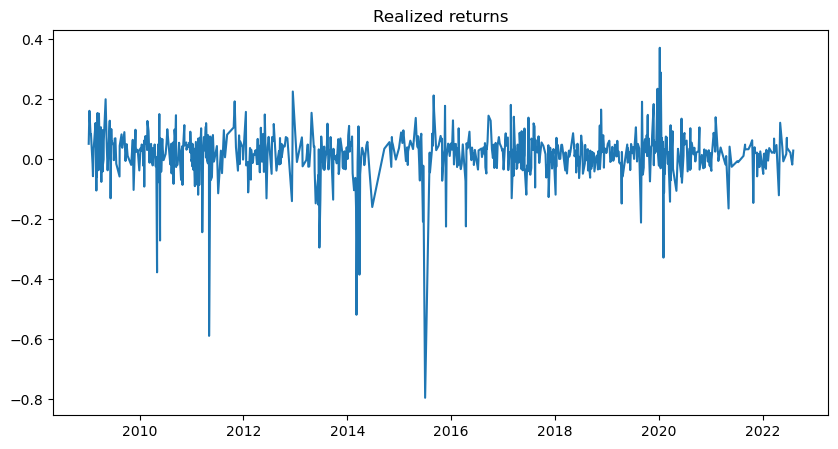

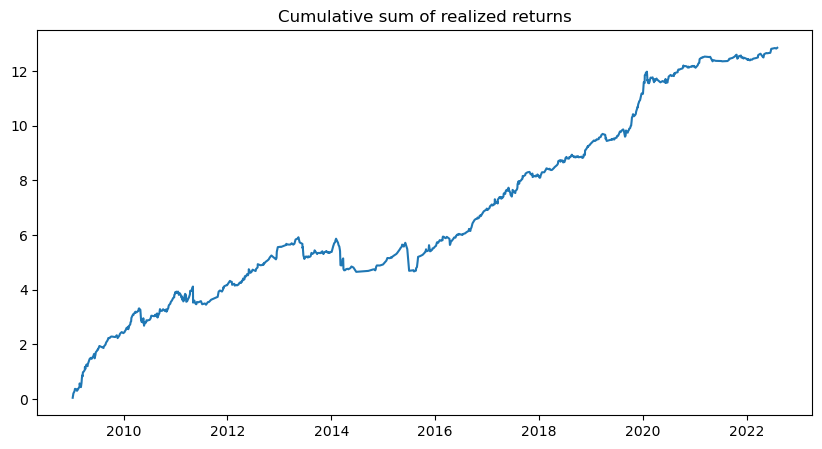

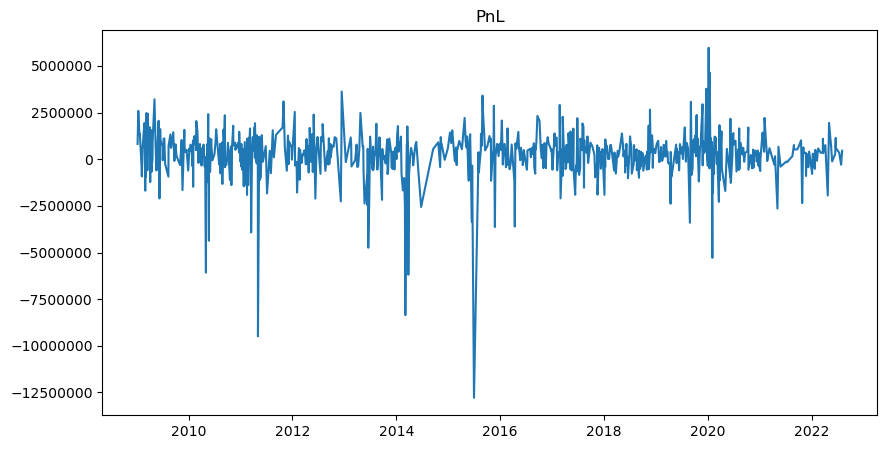

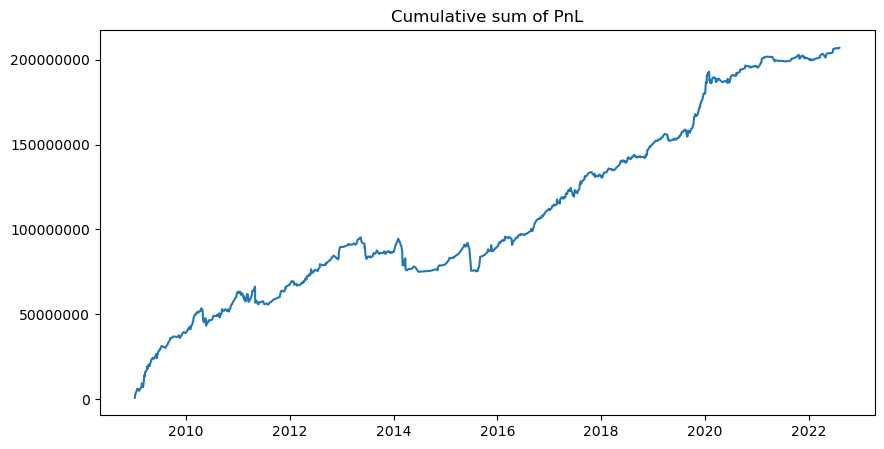

In [116]:
plt.figure(figsize=(10, 5))
plt.title('Realized returns')
plt.plot(rreturns)

plt.figure(figsize=(10, 5))
plt.title('Cumulative sum of realized returns')
plt.plot(cumrreturns)

plt.figure(figsize=(10, 5))
plt.title('PnL')
plt.ticklabel_format(useOffset=False, style='plain')
plt.plot(pnls)

plt.figure(figsize=(10, 5))
plt.title('Cumulative sum of PnL')
plt.ticklabel_format(useOffset=False, style='plain')
plt.plot(cumpnls)